# **Capstone Project**

#ASAH (Aplikasi Sortir Sampah)

Ini merupakan Repository untuk pembuatan model machine learning klasifikasi gambar

# **Import Library**

Diperlukan import library berikut untuk mengerjakan proyek ini.


In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import random, cv2, os, zipfile, PIL, pathlib
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications.vgg16 import VGG16

print('setup successful!')

setup successful!


# **Dataset Preparation**

Dataset yang digunakan adalah dataset Garbage Classification yang memuat 12 class. Dataset ini diperoleh dari kaggle dengan link: https://www.kaggle.com/datasets/mostafaabla/garbage-classification/code

In [ ]:
! pip install -q kaggle

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"{your_username}","key":"{your_api_key}"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

rm: cannot remove '/root/.kaggle': No such file or directory


In [ ]:
!kaggle datasets download -d mostafaabla/garbage-classification

 93% 223M/239M [00:00<00:00, 255MB/s]
100% 239M/239M [00:01<00:00, 248MB/s]


# **Zip Extraction**

Dataset yang telah diunduh sebelumnya masih dalam bentuk ekstensi file .zip sehingga diperlukan ekstraksi pada file tersebut agar file di dalamnya dapat diakses dengan mudah.

In [ ]:
local_zip = 'garbage-classification.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

In [ ]:
base_dir = '/content/garbage_classification'
os.listdir(base_dir)

['metal',
 'shoes',
 'battery',
 'white-glass',
 'clothes',
 'paper',
 'brown-glass',
 'cardboard',
 'trash',
 'biological',
 'green-glass',
 'plastic']

# **Split Dataset**

Proses selanjutnya adalah pembagian Dataset. Dataset akan dibagi menjadi train, validation, dan test set. Data train atau latih akan digunakan untuk membangun model, sedangkan data validation dan test akan digunakan untuk menguji performa model. Pada proyek ini akan dibagi menjadi 70% untuk train set data, 15% untuk cross validation test dan 15% untuk test set.

In [ ]:
! pip install split-folders
import splitfolders

base_dir = "garbage_classification"
base_ds = pathlib.Path(base_dir)

splitfolders.ratio(
    base_dir, 
    output = "imgs", 
    seed = 123, 
    ratio = (.7,.15,.15), 
    group_prefix = None
)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 15515 files [00:04, 3559.66 files/s]


# **Labeling Class**

Selanjutnya diperlukan deklarasi dari kelas yang tersedia dalam dataset. Pada dataset tersebut terdapat 12 kelas beras yaitu Paper, Cardboard, Plastic, Metal, Trash, Battery, Shoes, Clothes, Green-Glass, Brown-Glass, White-Glass, dan Biological. Berikut adalah proses pengelompokan kelas dan pemberian label pada dataset.

In [ ]:
garbage_label = ['battery',
    'biological',
    'brown-glass',
    'cardboard',
    'clothes',
    'green-glass',
    'metal',
    'paper',
    'plastic',
    'shoes',
    'trash',
    'white-glass'
 ]

paper = [fn for fn in os.listdir(f'{base_dir}/paper') if fn.endswith('.jpg')]
cardboard = [fn for fn in os.listdir(f'{base_dir}/cardboard') if fn.endswith('.jpg')]
plastic = [fn for fn in os.listdir(f'{base_dir}/plastic') if fn.endswith('.jpg')]
metal = [fn for fn in os.listdir(f'{base_dir}/metal') if fn.endswith('.jpg')]
trash = [fn for fn in os.listdir(f'{base_dir}/trash') if fn.endswith('.jpg')]
battery = [fn for fn in os.listdir(f'{base_dir}/battery') if fn.endswith('.jpg')]
shoes = [fn for fn in os.listdir(f'{base_dir}/shoes') if fn.endswith('.jpg')]
clothes = [fn for fn in os.listdir(f'{base_dir}/clothes') if fn.endswith('.jpg')]
green_glass = [fn for fn in os.listdir(f'{base_dir}/green-glass') if fn.endswith('.jpg')]
brown_glass = [fn for fn in os.listdir(f'{base_dir}/brown-glass') if fn.endswith('.jpg')]
white_glass = [fn for fn in os.listdir(f'{base_dir}/white-glass') if fn.endswith('.jpg')]
biological = [fn for fn in os.listdir(f'{base_dir}/biological') if fn.endswith('.jpg')]
garbage = [battery, biological, brown_glass, cardboard, clothes, green_glass, metal, paper, plastic, shoes, trash, white_glass]

# **Print Dataset**

Melakukan percobaan untuk melihat jumlah masing-masing gambar pada setiap class

Jumlah Gambar Sampah: battery        945
Jumlah Gambar Sampah: biological     985
Jumlah Gambar Sampah: brown-glass    607
Jumlah Gambar Sampah: cardboard      891
Jumlah Gambar Sampah: clothes       5325
Jumlah Gambar Sampah: green-glass    629
Jumlah Gambar Sampah: metal          769
Jumlah Gambar Sampah: paper         1050
Jumlah Gambar Sampah: plastic        865
Jumlah Gambar Sampah: shoes         1977
Jumlah Gambar Sampah: trash          697
Jumlah Gambar Sampah: white-glass    775



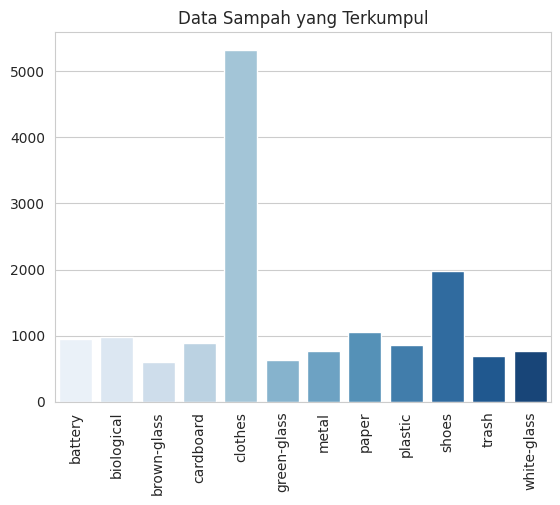


Total Varian Sampah 		: 12
Total Jumlah Gambar Sampah 	: 15515


In [ ]:
garbage_count = []
for i in range(len(garbage)):
    print(f"Jumlah Gambar Sampah: {garbage_label[i]:<12} {len(garbage[i]):>5}")
    garbage_count.append(len(garbage[i]))

print()

sns.set_style('whitegrid')
ax = sns.barplot(x=garbage_label, y=garbage_count, palette="Blues")
ax.set(title="Data Sampah yang Terkumpul")
ax.set_xticklabels(garbage_label, rotation=90)
plt.show()

print()

print("Total Varian Sampah \t\t:", len(garbage))
print("Total Jumlah Gambar Sampah \t:", sum(garbage_count))

# **Augmentasi Gambar**

Mencoba untuk memperbanyak data train dengan cara menduplikasi gambar yang telah ada dengan menambahkan variasi tertentu

In [ ]:
datagen = ImageDataGenerator(
    rescale=1./255,
)

# **Flow Train Set, Validation Set, and Test Set**


In [ ]:
train_set = datagen.flow_from_directory(
    'imgs/train',
    
    target_size=(175, 175),
    batch_size=64,
    subset="training",
    class_mode='categorical',
)

val_set = datagen.flow_from_directory(
    'imgs/val',
    target_size=(175, 175),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

test_set = datagen.flow_from_directory(
    'imgs/test',
    target_size=(175, 175),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)

Found 10854 images belonging to 12 classes.
Found 2321 images belonging to 12 classes.
Found 2340 images belonging to 12 classes.


# **Save Model**

In [ ]:
model_dir = "model_saved"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

checkpointer = ModelCheckpoint(
    filepath = model_dir + '/base_model.hdf5', 
    monitor = 'val_accuracy', 
    mode = 'max',
    verbose = 1, 
    save_best_only = True
)

# **Implement VGG16**

VGG16 adalah salah satu arsitektur Convolutional Neural Network (CNN) yang sangat populer dan sering digunakan dalam tugas pengenalan gambar.

VGG16 terdiri dari 16 lapisan (layers), termasuk 13 lapisan konvolusi (convolutional layers) dan 3 lapisan terhubung penuh (fully connected layers). 

In [ ]:
vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=(175, 175, 3))
vgg16.trainable = False
inputs = tf.keras.Input((175, 175, 3))
x = vgg16(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(12, activation='softmax')(x)
model_vgg16 = tf.keras.Model(inputs, x)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 175, 175, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 5, 5, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              525312    
                                                                 
 dense_1 (Dense)             (None, 12)                12300     
                                                                 
Total params: 15,252,300
Trainable params: 537,612
Non-trainable params: 14,714,688
___________________________________________

In [ ]:
checkpointer = ModelCheckpoint(
    filepath='saved_models/model_vgg16.hdf5', 
    monitor='val_accuracy', 
    mode='max',
    verbose=1, 
    save_best_only=True
)

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=2, min_lr=0.001)
callbacks=[early_stopping, reduce_lr, checkpointer]

In [ ]:
history2 = model_vgg16.fit(
    train_set, 
    epochs = 40,
    validation_data = val_set, 
    callbacks=callbacks
)

Epoch 1/40
170/170 [==============================] - ETA: 0s - loss: 0.9376 - accuracy: 0.7118
Epoch 1: val_accuracy improved from -inf to 0.79405, saving model to saved_models/model_vgg16.hdf5
170/170 [==============================] - 69s 310ms/step - loss: 0.9376 - accuracy: 0.7118 - val_loss: 0.6597 - val_accuracy: 0.7941 - lr: 0.0010
Epoch 2/40
170/170 [==============================] - ETA: 0s - loss: 0.5527 - accuracy: 0.8254
Epoch 2: val_accuracy improved from 0.79405 to 0.82508, saving model to saved_models/model_vgg16.hdf5
170/170 [==============================] - 46s 271ms/step - loss: 0.5527 - accuracy: 0.8254 - val_loss: 0.5524 - val_accuracy: 0.8251 - lr: 0.0010
Epoch 3/40
170/170 [==============================] - ETA: 0s - loss: 0.4642 - accuracy: 0.8520
Epoch 3: val_accuracy improved from 0.82508 to 0.82723, saving model to saved_models/model_vgg16.hdf5
170/170 [==============================] - 44s 257ms/step - loss: 0.4642 - accuracy: 0.8520 - val_loss: 0.5266 - va

# **Accuracy and Plot Lost Graph Model VGG16**

Furthermore, the Import Library Matphlotlib will be used to present the accuracy graph and loss plot during training and validation. The following is the implementation of using the library to present the accuracy graph and loss plot.

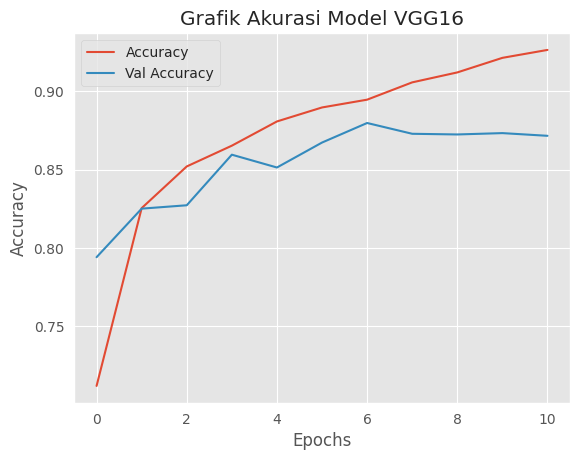

In [ ]:
plt.style.use('ggplot')
plt.title("Grafik Akurasi Model VGG16")
plt.plot(history2.history['accuracy'], label = 'Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

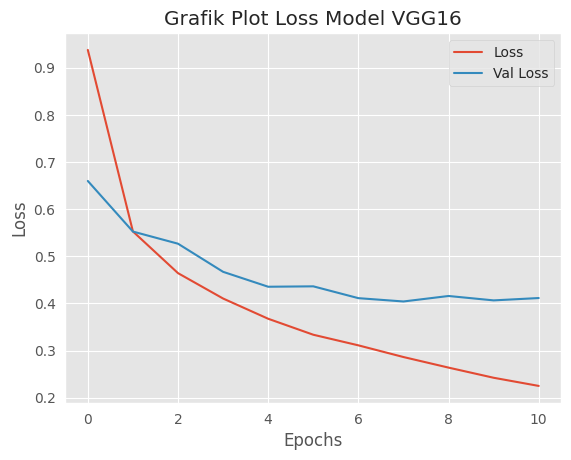

In [ ]:
plt.style.use('ggplot')
plt.title("Grafik Plot Loss Model VGG16")
plt.plot(history2.history['loss'], label = 'Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Testing Model**

With this modification, after training and evaluating the model, the code prompts the user to upload an image. The uploaded image is then loaded, preprocessed, and reshaped to match the input shape of the model. Finally, the model makes predictions on the uploaded image, and the predicted class label is displayed.

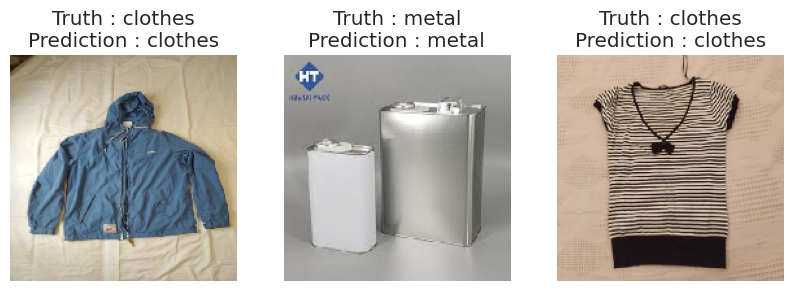

In [ ]:
plt.figure(figsize=(10, 10))
x, label= train_set.next()
for i in range(3):
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i])
    result = np.where(label[i]==1)
    predict = model_vgg16(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = garbage_label[np.argmax(score)]
    plt.title("Truth : " + garbage_label[result[0][0]] + "\nPrediction : " + score_label)
    plt.axis(False)

Saving WhatsApp Image 2023-05-17 at 21.18.45.jpeg to WhatsApp Image 2023-05-17 at 21.18.45 (3).jpeg
1/1 [==============================] - 0s 18ms/step


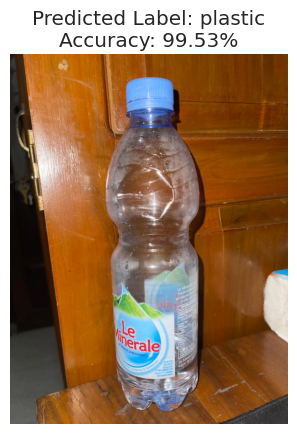

In [ ]:
# Prompt the user for image paths
uploaded = files.upload()

# Process each uploaded image
for image_path in uploaded.keys():
    # Load and preprocess the input image
    image = cv2.imread(image_path)
    image = cv2.resize(image, (175, 175))
    image = image / 255.0  # Normalize the image

    # Reshape the image to match the input shape of the model
    image = np.reshape(image, (1, 175, 175, 3))

    # Make predictions using the trained model
    predictions = model_vgg16.predict(image)

    # Get the predicted class label and accuracy
    predicted_label = garbage_label[np.argmax(predictions)]
    accuracy = predictions[0][np.argmax(predictions)]

    # Display the image, predicted label, and accuracy
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"Predicted Label: {predicted_label}\nAccuracy: {accuracy:.2%}")
    plt.axis('off')
    plt.show()